## Chapter 12: Introduction to nonlinear learning

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
import matplotlib.pyplot as plt
from autograd.misc.flatten import flatten_func

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
optimizers = optlib.optimizers
normalizers = superlearn.normalizers 
static_plotter = optlib.static_plotter.Visualizer()
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>


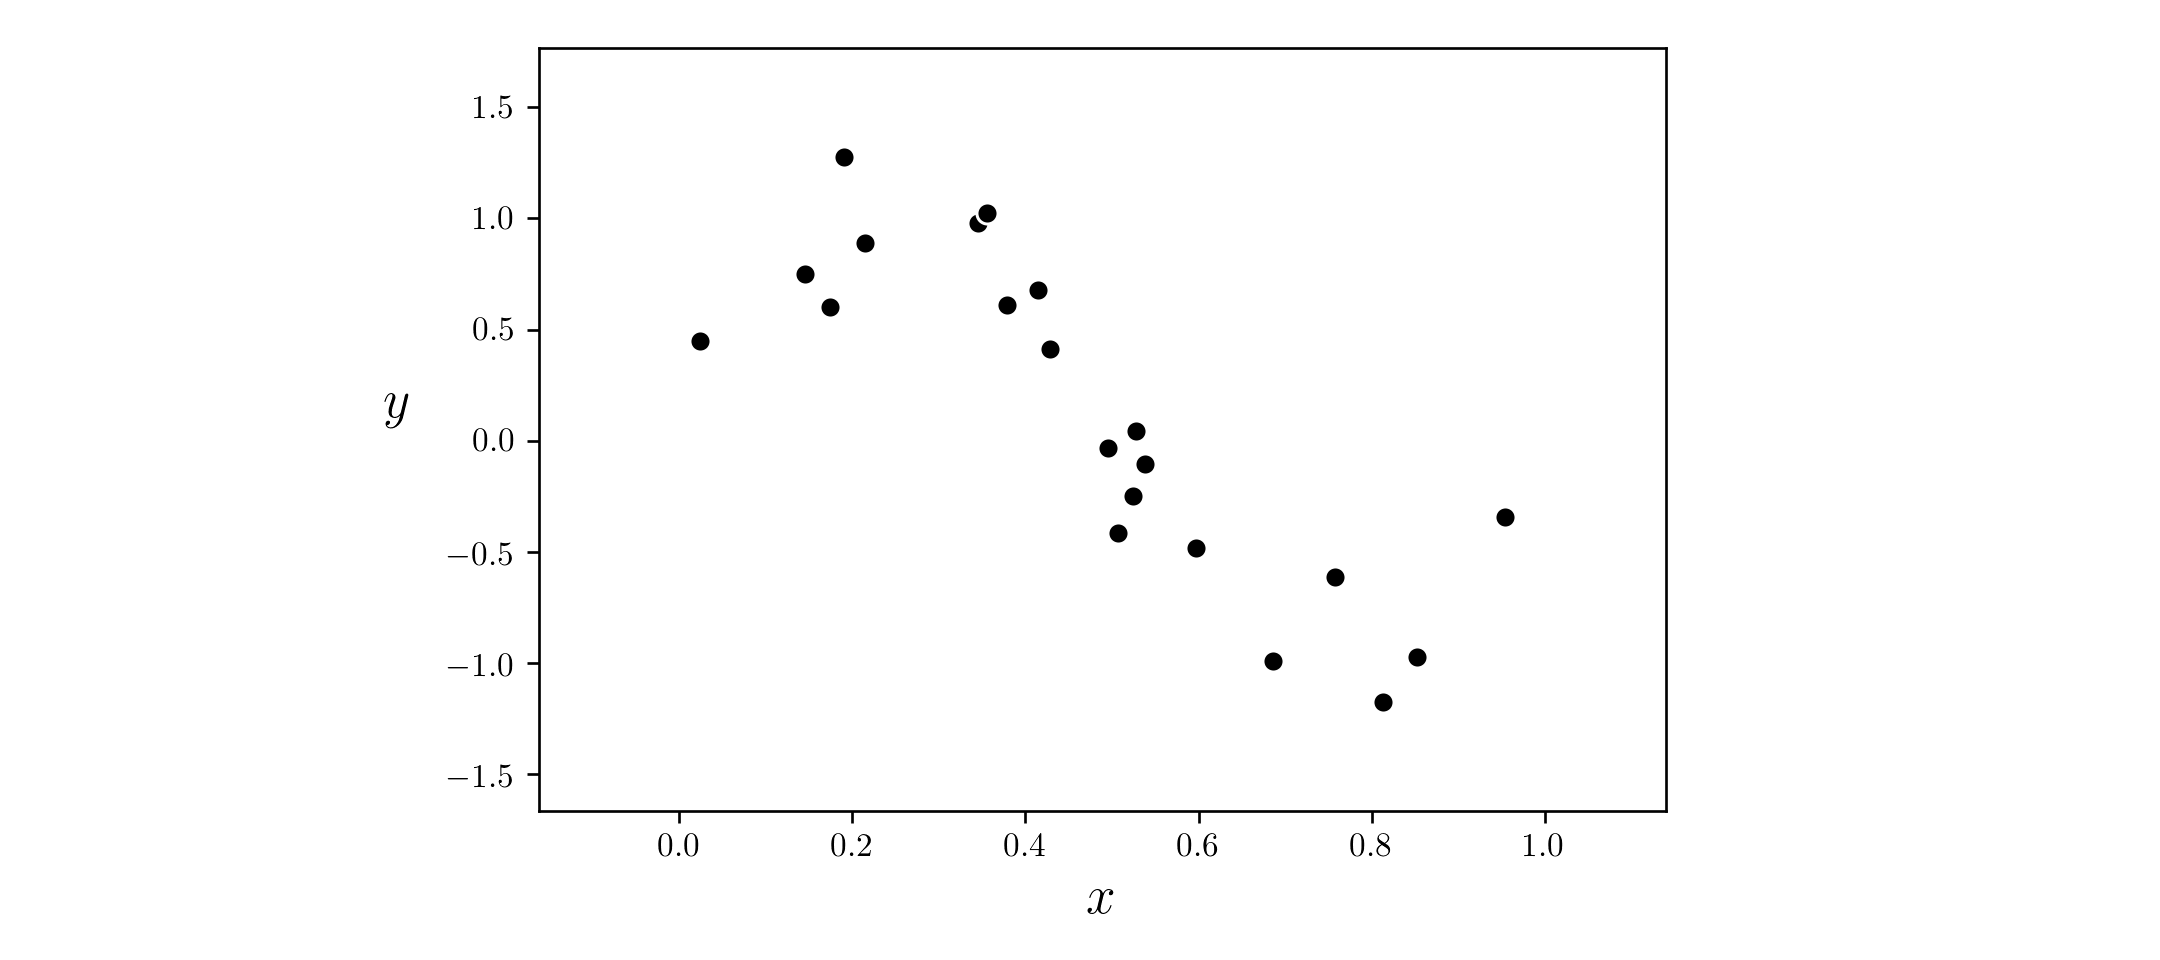

In [2]:
# load data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1].T
y = data[:,-1:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

TypeError: can't multiply sequence by non-int of type 'float'

TypeError: can't multiply sequence by non-int of type 'float'

In [18]:
# import cost funcs
cost = nonlib.cost_functions.Choose_Cost(x,y,feature_transform,cost = 'least_squares')

# set random initialization and run gradient descent on standard normalized input
g = cost.cost_func; max_its = 400; alpha_choice = 10**(-1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

In [19]:
cost.cost_func(w)

2.2657718636806408

In [3]:
# choose a nonlinear activation function 
def activation(t):
    # a relu function
    nonlinearity = np.maximum(0,t)  # default is the relu function
    return nonlinearity

# fully evaluate our network features using the tensor of weights in omega_inner
def feature_transform(a, w):    
    # loop through each layer matrix
    for W in w:
        #  pad with ones (to compactly take care of bias) for next layer computation
        o = np.ones((1,np.shape(a)[1]))
        a_padded = np.vstack((o,a))
        
        # output of layer activation
        a = activation(np.dot(W.T,a_padded))
    return a

# compute linear combination of input point
def model(x,w):    
    # feature transformation 
    f = feature_transform(x,w[0])
    
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(f)[1]))
    f = np.vstack((o,f))
    
    # compute linear combination and return
    a = np.dot(f.T,w[1])
    return a

In [9]:
# create normalizer
normalizer = normalizers.standard_normalizer(x)

# normalize input 
x_normalized = normalizer(x)

In [8]:
# create initial weights for arbitrary feedforward network
def initialize_network_weights(layer_sizes,scale):
    # container for entire weight tensor
    weights = []
    
    # loop over desired layer sizes and create appropriately sized initial 
    # weight matrix for each layer
    for k in range(len(layer_sizes)-1):
        # get layer sizes for current weight matrix
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight = scale*np.random.randn(U_k + 1,U_k_plus_1)
        weights.append(weight)

    # re-express weights so that w_init[0] = omega_inner contains all 
    # internal weight matrices, and w_init = w contains weights of 
    # final linear combination in predict function
    w_init = [weights[:-1],weights[-1]]
    
    return w_init

In [9]:
# An example 4 hidden layer network, with 10 units in each layer
N = np.shape(x)[0]
M = np.shape(y)[1]
U_1 = 10
U_2 = 10
U_3 = 10
U_4 = 10

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,U_4,M]

# generate initial weights for our network
w = initialize_network_weights(layer_sizes,scale = 0.5)

In [80]:
least_squares_2(w)

8.4068341947754757

In [87]:
least_squares = nonlib.cost_functions.choose_cost(x_normalized,y,model,cost = 'least_squares')

# declare an instance of our current our optimizers
opt = nonlib.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
weight_history_1 = opt.gradient_descent(g = least_squares,w = w,max_its = 1000,alpha = 10**(-1),version = 'normalized',output = 'history')

In [82]:
# # set random initialization and run gradient descent on original data
# least_squares_2 = nonlib.cost_functions.choose_cost(x_normalized,y,model,cost = 'least_squares')

# # set random initialization and run gradient descent on standard normalized input
# g = least_squares_2; max_its = 400; alpha_choice = 10**(-1);
# weight_history_2,cost_history_2 = optimizers.gradient_descent(g,alpha_choice,max_its,w)

TypeError: can't multiply sequence by non-int of type 'float'

Now we compare the cost function histories of each run in the cost function plot below.  This sort of result is very typical of nonlinear regression and while we will not normalize the input of every *toy* example discussed in this and the next Sections for reasons of clarity, it serves as an important reminder that in practice one should *never forget to normalize input* when tuning a nonlinear supervised learner via gradient descent.  The run on the original data is actually somewhat deceiving here - it converges but not to the global minimum achieved using the normalized input.

<IPython.core.display.Javascript object>


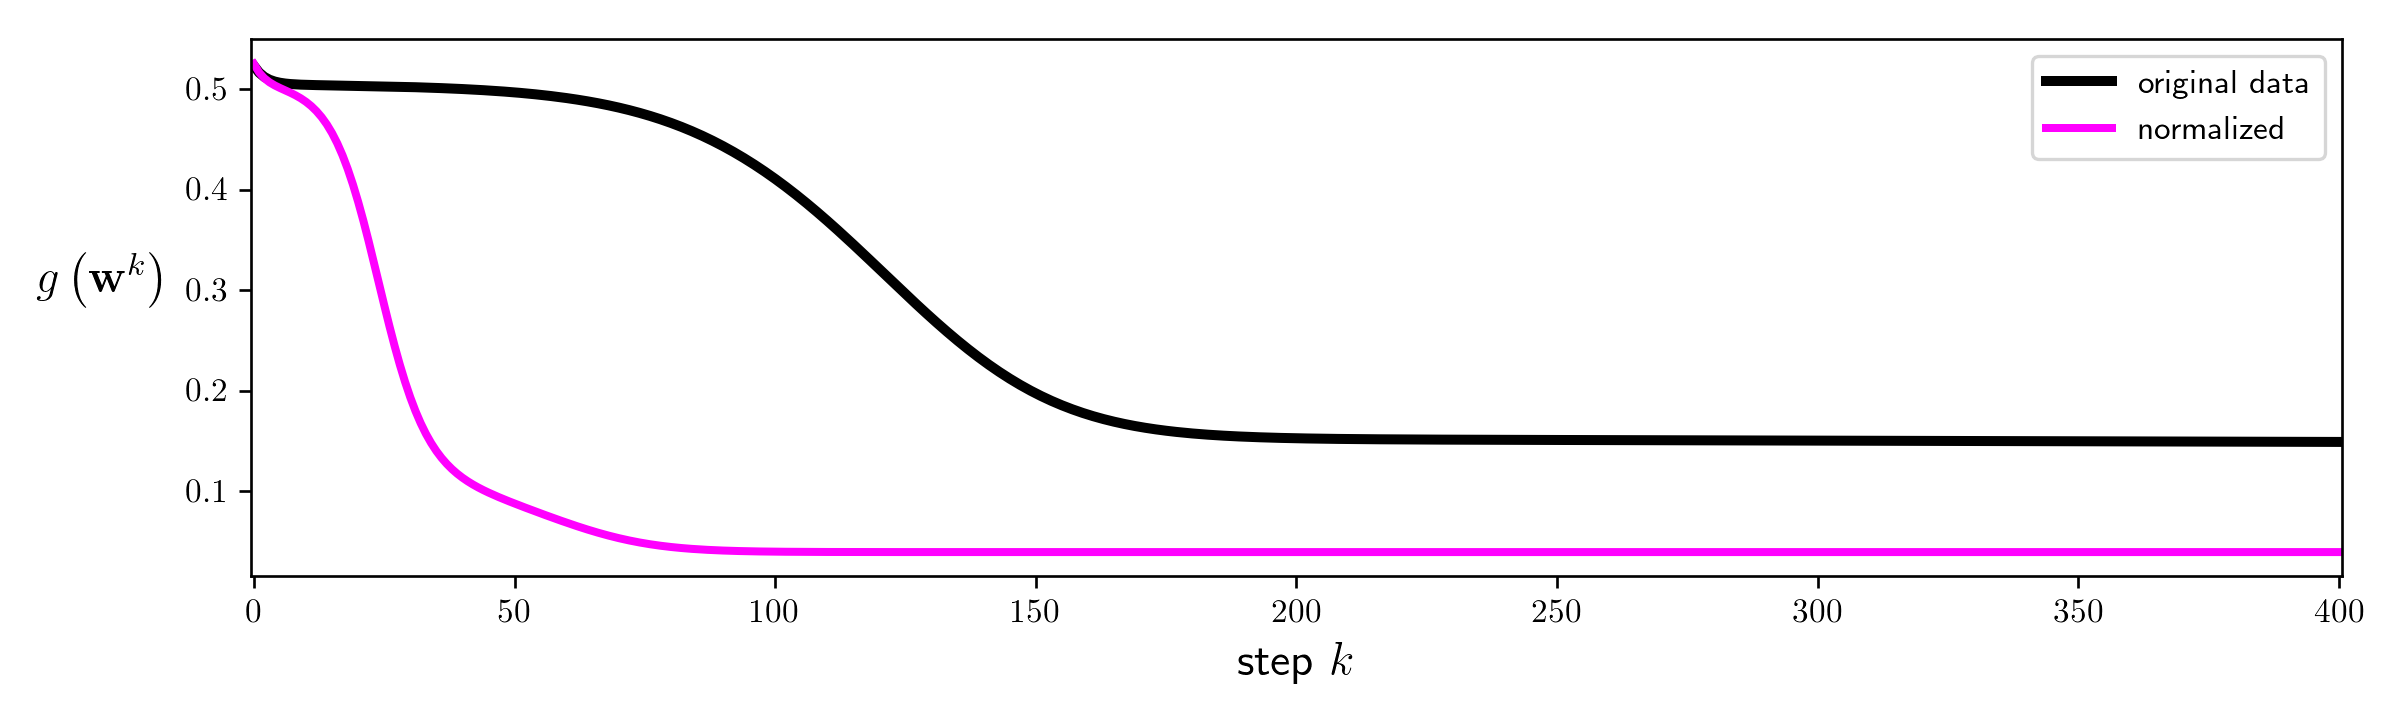

In [123]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = False,labels = ['original data','normalized'])

We can then plot the resulting fit to the data provided by the run on the normalized input - and achieve quite a good fit.

<IPython.core.display.Javascript object>


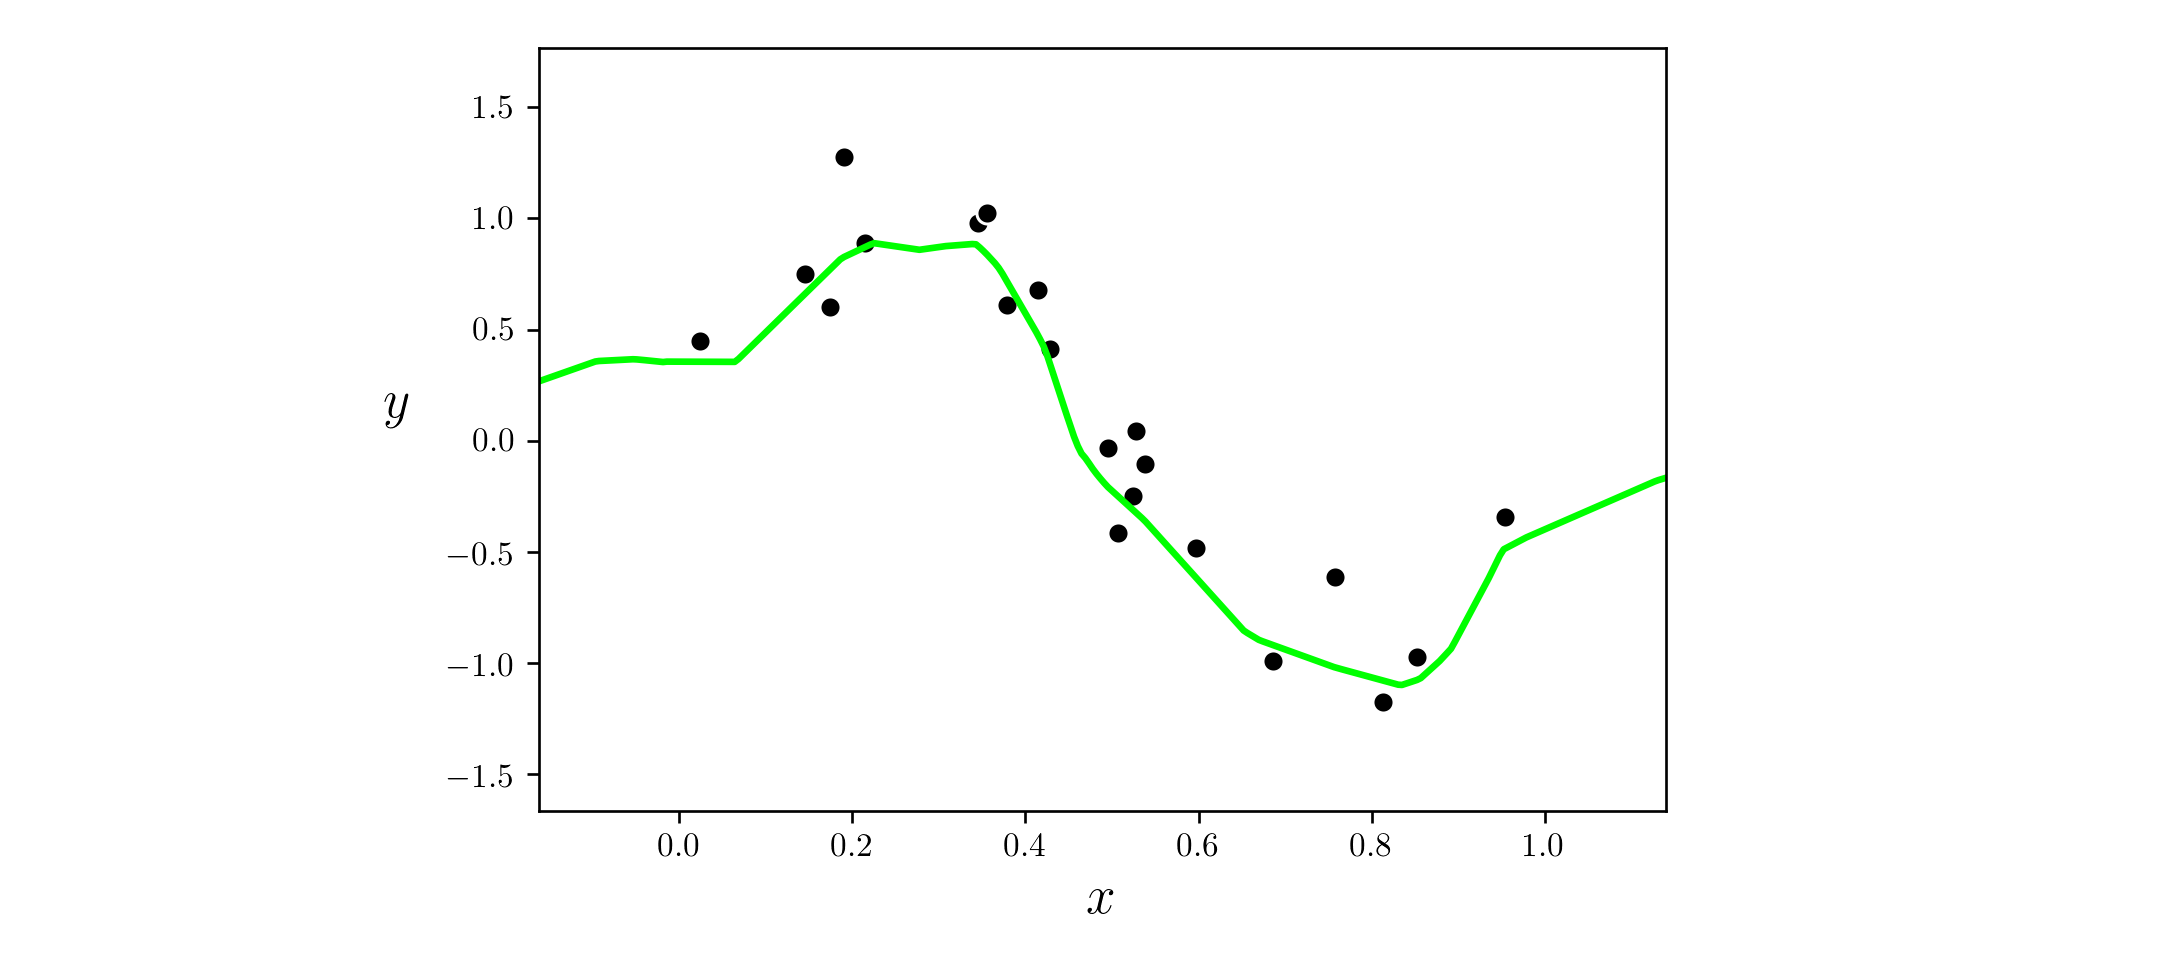

In [88]:
# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
w_best = weight_history_1[-1]
demo.plot_fit(w_best,model,normalizer = normalizer);

Note then that since we have used standard normalization to scale our input, we can write our feature transformation as 

\begin{equation}
f\left(x_p,\mathbf{w}\right) = \text{sin}\left(w_0 + w_1\frac{x_p - \mu}{\sigma}\right)
\end{equation}

where $\mu$ and $\sigma$ are the mean and standard deviation of our input data respectively.

With our weights fully tuned to our ideal parameters $\mathbf{w}^{\star}$ notice that  since `model` is defined *linearly* in terms of its feature transformation we can represent our transformed input $x_p \longleftarrow f\left(x_p,\mathbf{w}^{\star}\right)$ and the correspnoding model fit $
\text{model}\left(x,\mathbf{w}^{\star}\right)$ in what is called the *transformed feature space*.  This is simply the space whose input is the feature transformed input $\left(x,\mathbf{w}^{\star}\right)$ and whose output remains as $y$.  In this space our *nonlinear* fit is a *linear* one.  In other words, with our model completely tuned if plot the points $\left(f\left(x_1,\mathbf{w}^{\star}\right),y_1\right),\,\left(f\left(x_2,\mathbf{w}^{\star}\right),y_2\right)...,\left(f\left(x_P,\mathbf{w}^{\star}\right),y_P\right)$ - as we do below in the right panel - our model fits the transformed data *linearly*.

This finding is true in general with nonlinear regression problems.

> A properly designed feature (or set of features) provides a good nonlinear fit in the original feature space and, simultaneously, a good linear fit in the transformed feature space.

<IPython.core.display.Javascript object>


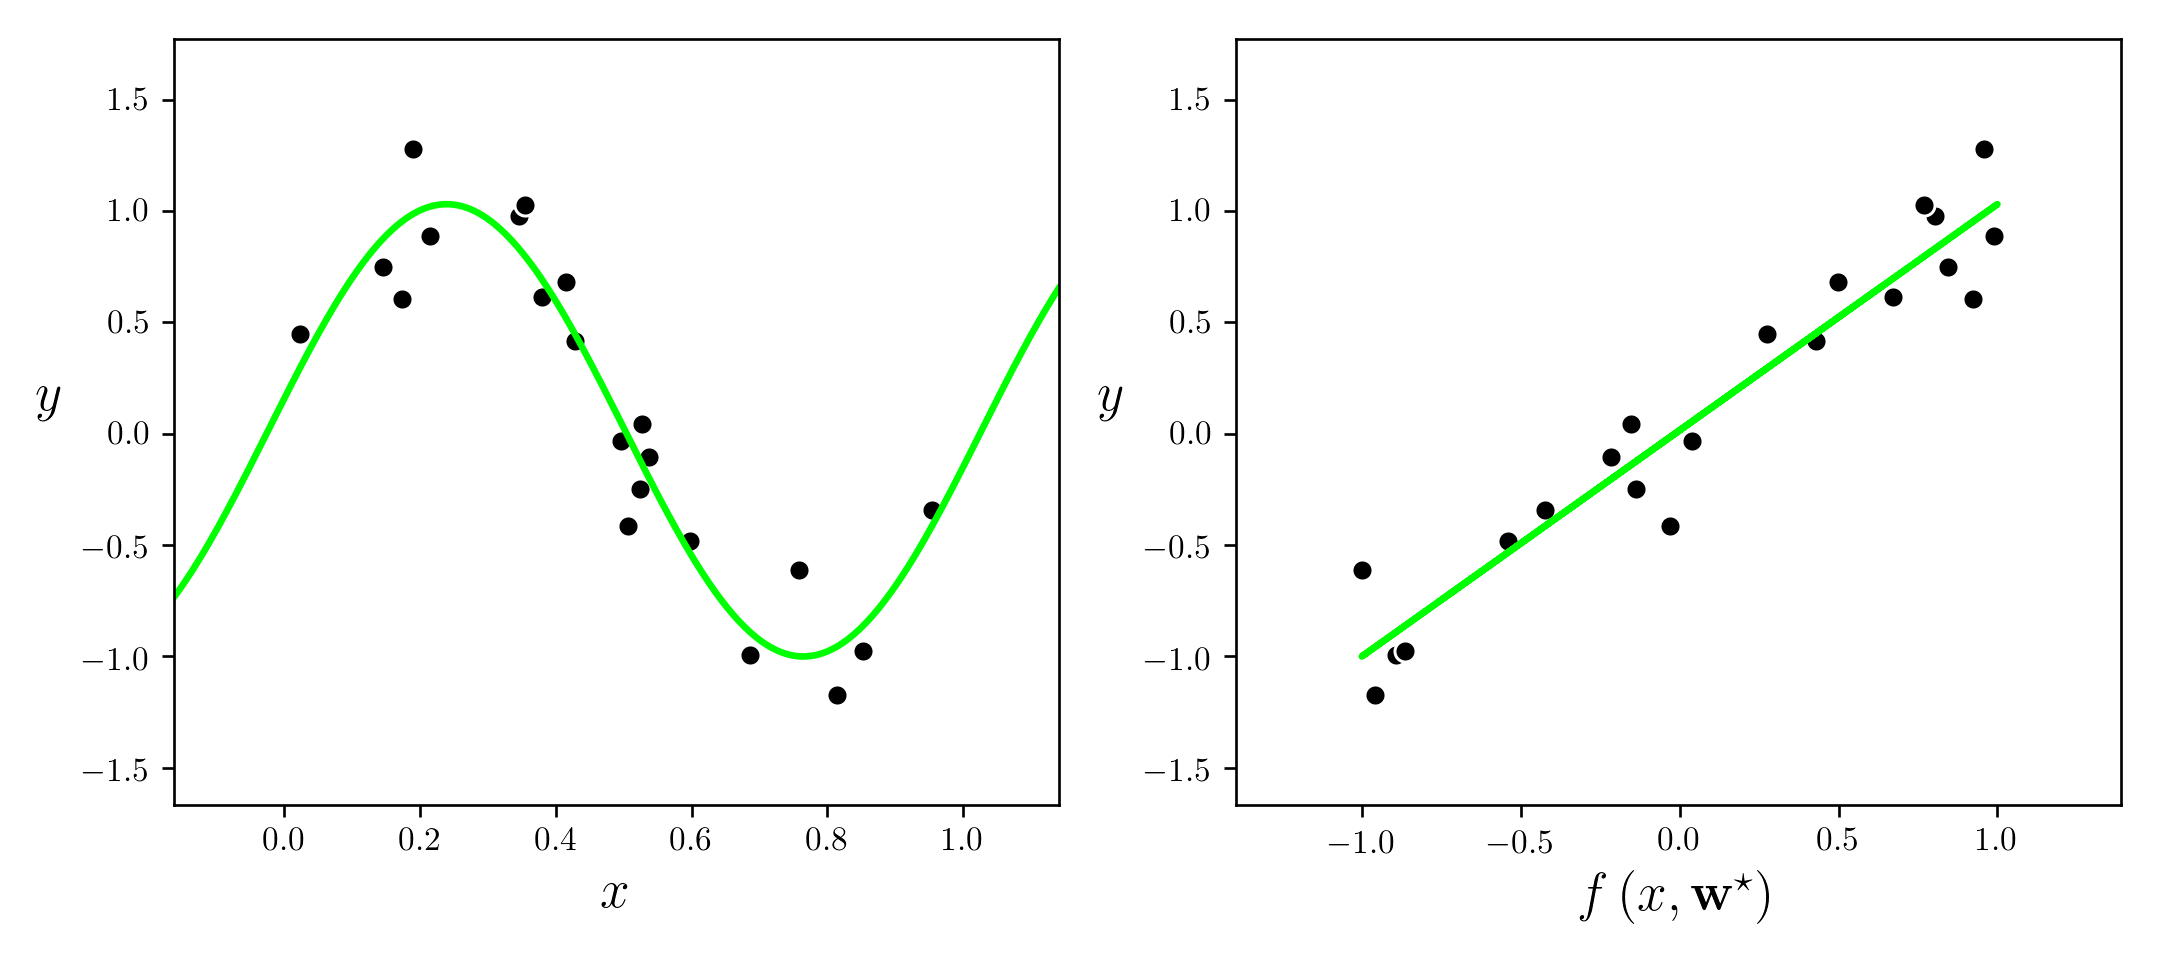

In [126]:
# plot data and fit in original and feature transformed space
demo.plot_fit_and_feature_space(w_best,model,feature_transform,normalizer = normalizer)

#### <span style="color:#a50e3e;">Example 4. </span> A population growth example

Next we examine a population growth dataset - which shows the population of Yeast cells growing in a constrained chamber (you can find the [source of this dataset here](http://math.arizona.edu/~dsl/byeast.htm)).  This is a common shape found with population growth data, where the creature under study starts off with only a few members and is only limited in growth by how fast it can reproduce and the resources available in its environment.  In the beginning such a population grows exponentially.  This growth halts rapidly when the population reaches the maximum carrying capacity of its environment.

<IPython.core.display.Javascript object>


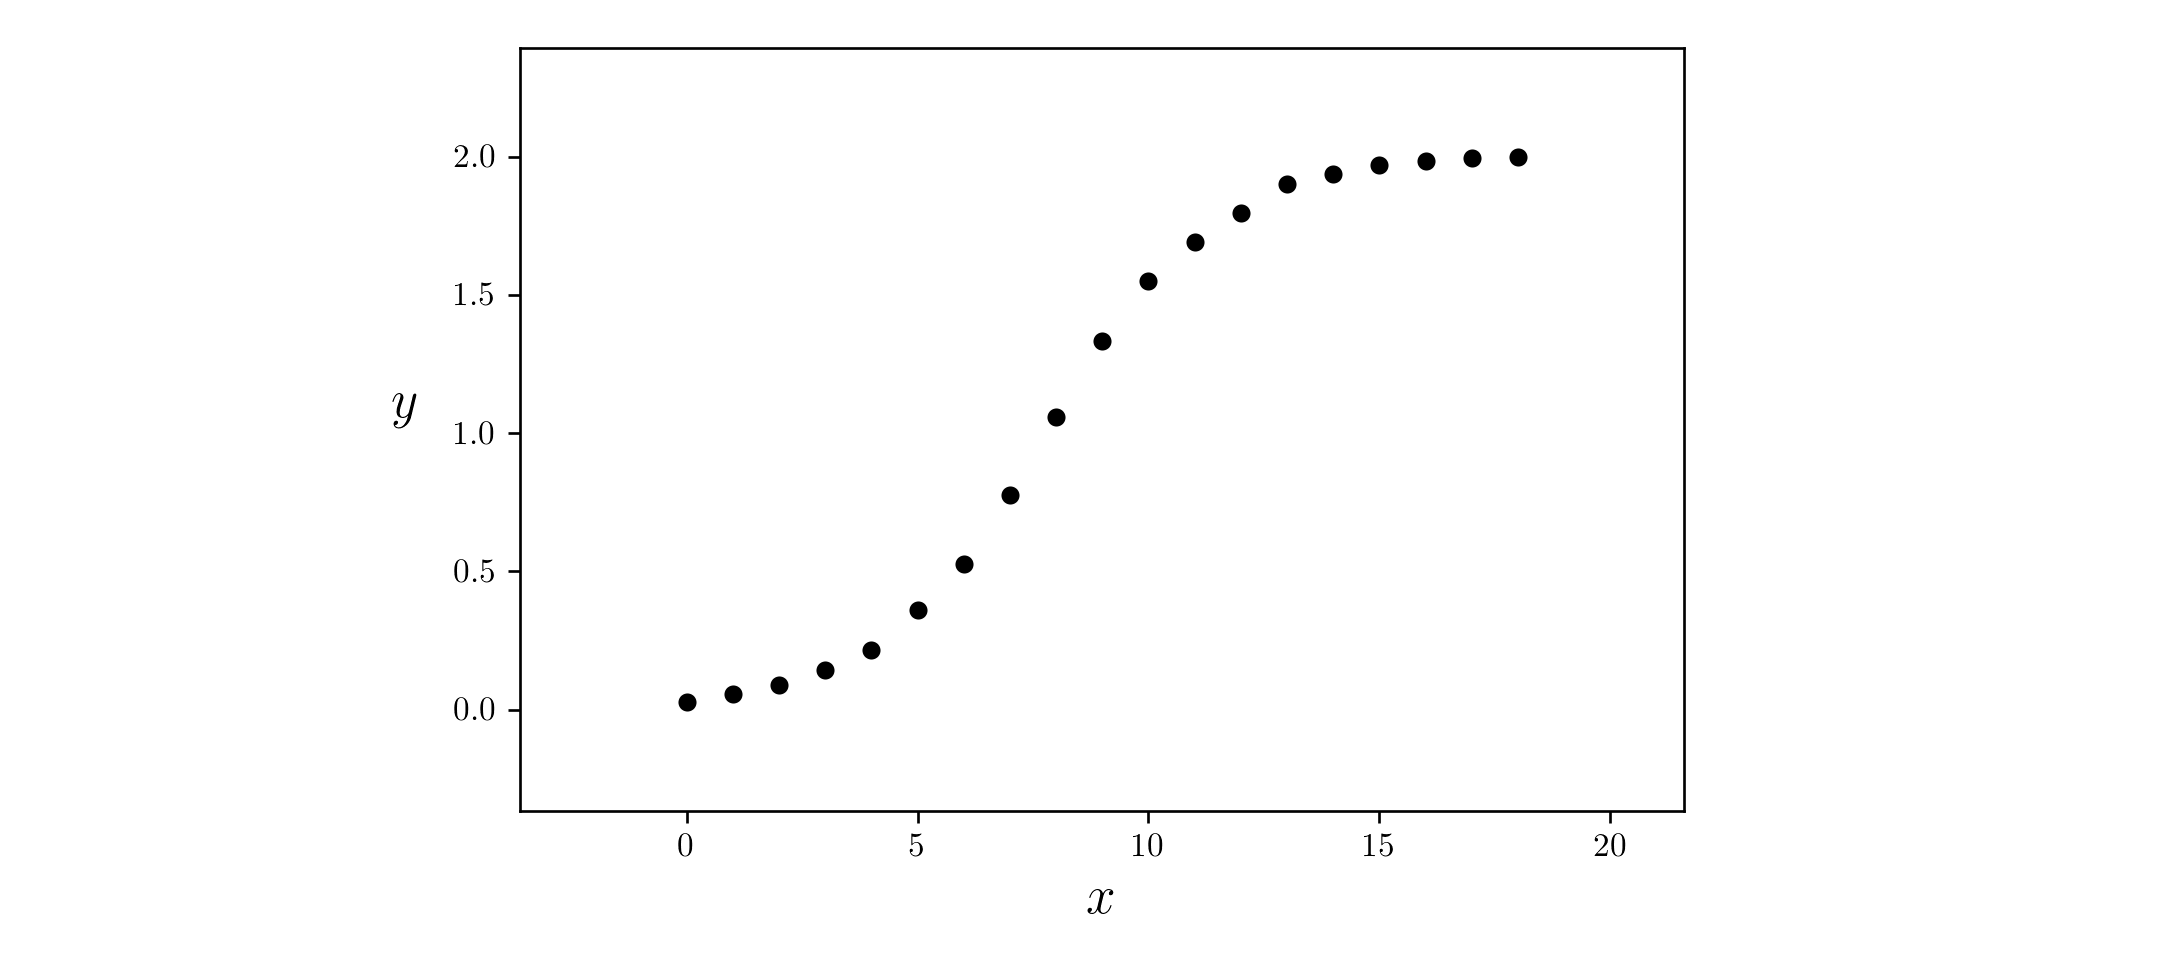

In [12]:
# load data
csvname = datapath + 'yeast.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:,:-1].T
y = data[:,-1:]

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

If we take a moment and visually examine this dataset, it appears that some sort of logistic sigmoid / hyperbolic tangent nonlinearity would fit it quite well.  So using a tanh feature transformation 

\begin{equation}
f\left(x_p,\mathbf{w}\right) = \text{tanh}\left(w_0 + w_1x_p\right).
\end{equation}

we can then take as our `model` a linear combination of this nonlinear feature transformation as

\begin{equation}
\text{model}\left(x_p,\mathbf{w}_{\!}\right) = w_2 + w_{3\,}f\left(x_p,\mathbf{w}\right).
\end{equation}

Note here we are using the notation $\mathbf{w}$ rather loosely to represent whatever weights are present in the respective formula - for example in the feature transformation $\mathbf{w}$ consists of $w_0$ and $w_1$, whereas with the `model` it contains these weights as well as $w_2$ and $w_3$.

Below we show an implementation of this feature transformation and associated model.

In [16]:
# our nonlinearity, known as a feature transformation
def feature_transform(x,w):
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(x)[1]))
    x = np.vstack((o,x))
        
    # calculate feature transform
    f = np.tanh(np.dot(x.T,w)).T
    return f

# compute linear combination of input point
def model(x,w):    
    # feature transformation 
    f = feature_transform(x,w[0])
    
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(f)[1]))
    f = np.vstack((o,f))
    
    # compute linear combination and return
    a = np.dot(f.T,w[1])
    return a

Using the same functionality employed in the previous example, we normalize the input of this dataset (using standard normalization) since this virtually always helps speed up gradient descent significantly.  Note this means that our feature transformation can be written as

\begin{equation}
f\left(x_p,\mathbf{w}\right) = \text{tanh}\left(w_0 + w_1\frac{x_p - \mu}{\sigma}\right)
\end{equation}

where $\mu$ and $\sigma$ are the mean and standard deviation of our input data respectively.  We do not need to alter our feature transformation code above make this change, since it can be accomplished by feeding in the normalized input for training and the corresponding normalization function while evaluating test points.

Below we then form the corresponding Least Squares cost, and minimize it using gradient descent.  

In [101]:
# create normalizer
normalizer = normalizers.standard_normalizer(x)

# normalize input 
x_normalized = normalizer(x)

# get least squares cost with our given model
least_squares = nonlib.cost_functions.choose_cost(x_normalized,y,model,cost = 'least_squares')

# set random initialization and run gradient descent on standard normalized input
g = least_squares; alpha_choice = 10**(-1); max_its = 1000; 
w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)])
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

In [19]:
w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)])
runner = nonlib.basic_runner.Setup(x,y,feature_transform,'least_squares')
runner.fit(w=w)

In [24]:
a = runner.Setup(x,y,feature_transform,'least_squares')

In [25]:
a.fit(w=w)

To check the convergence of our run of gradient descent we show the corresponding cost function history plot below.

<IPython.core.display.Javascript object>


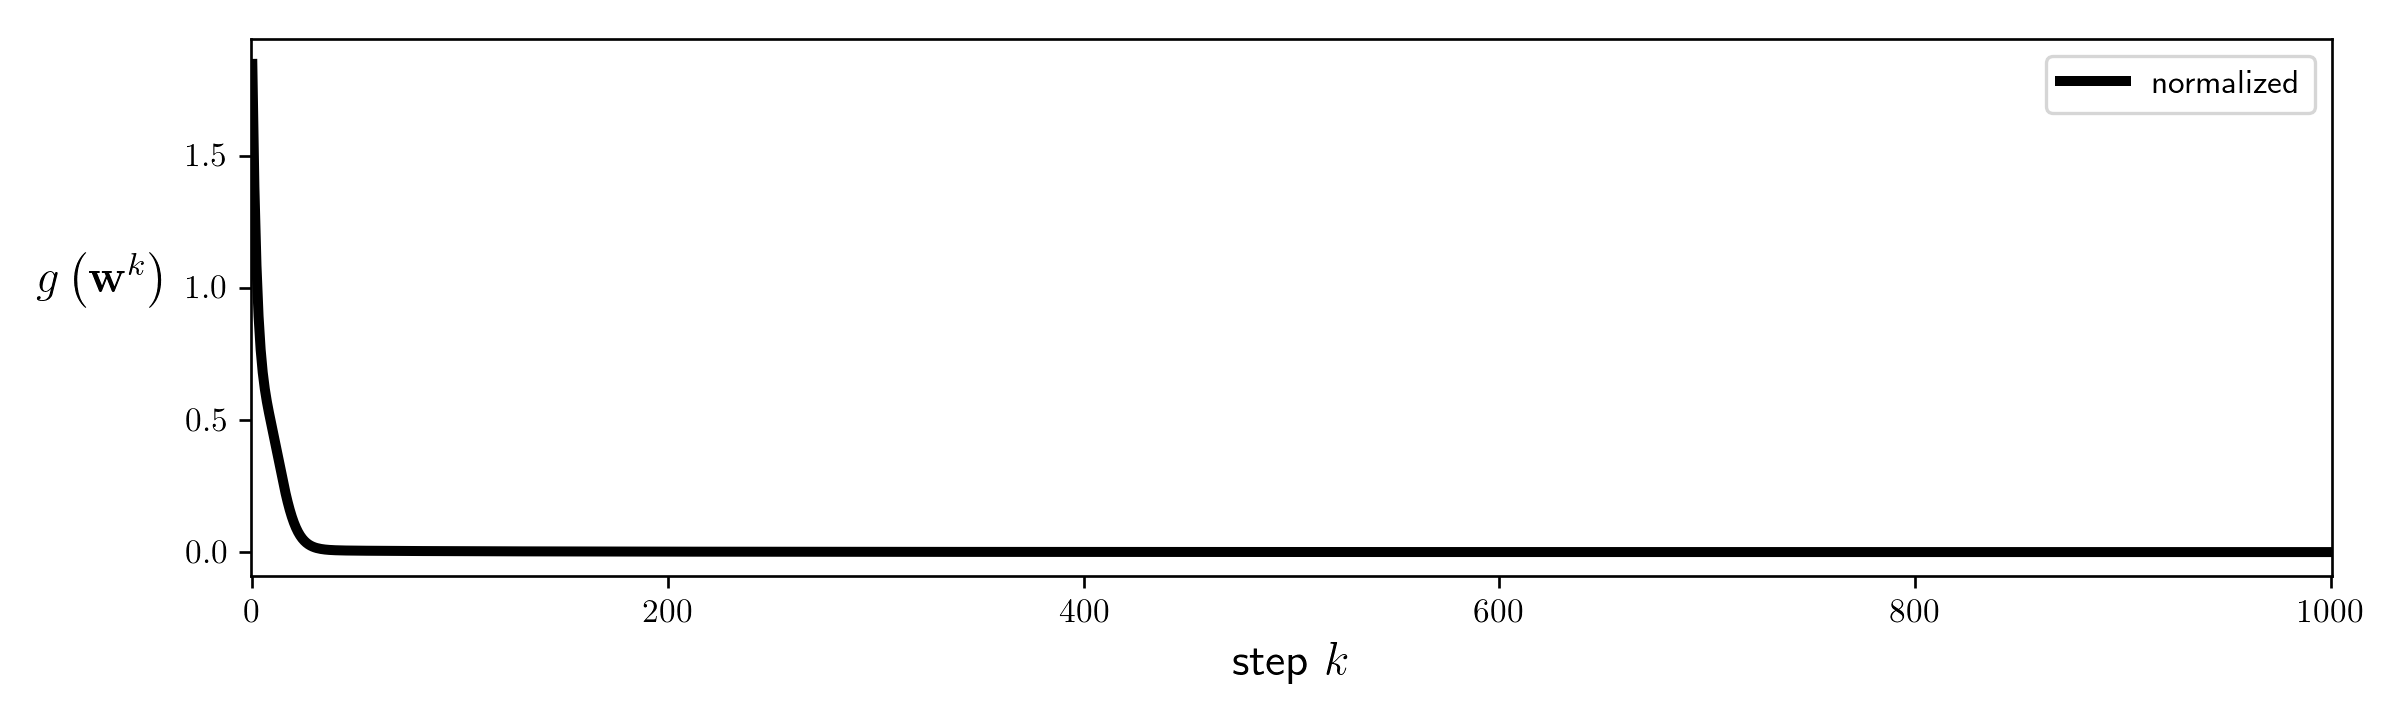

In [20]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([runner.cost_history],start = 0,points = False,labels = ['normalized'])

With our minimization complete we can then fit our `model` function in both the original space (where it provides a good nonlinear fit) as well as in the *transformed feature space* where it simultaneously provides a good linear fit to the transformed data (as discussed in the previous example).

<IPython.core.display.Javascript object>


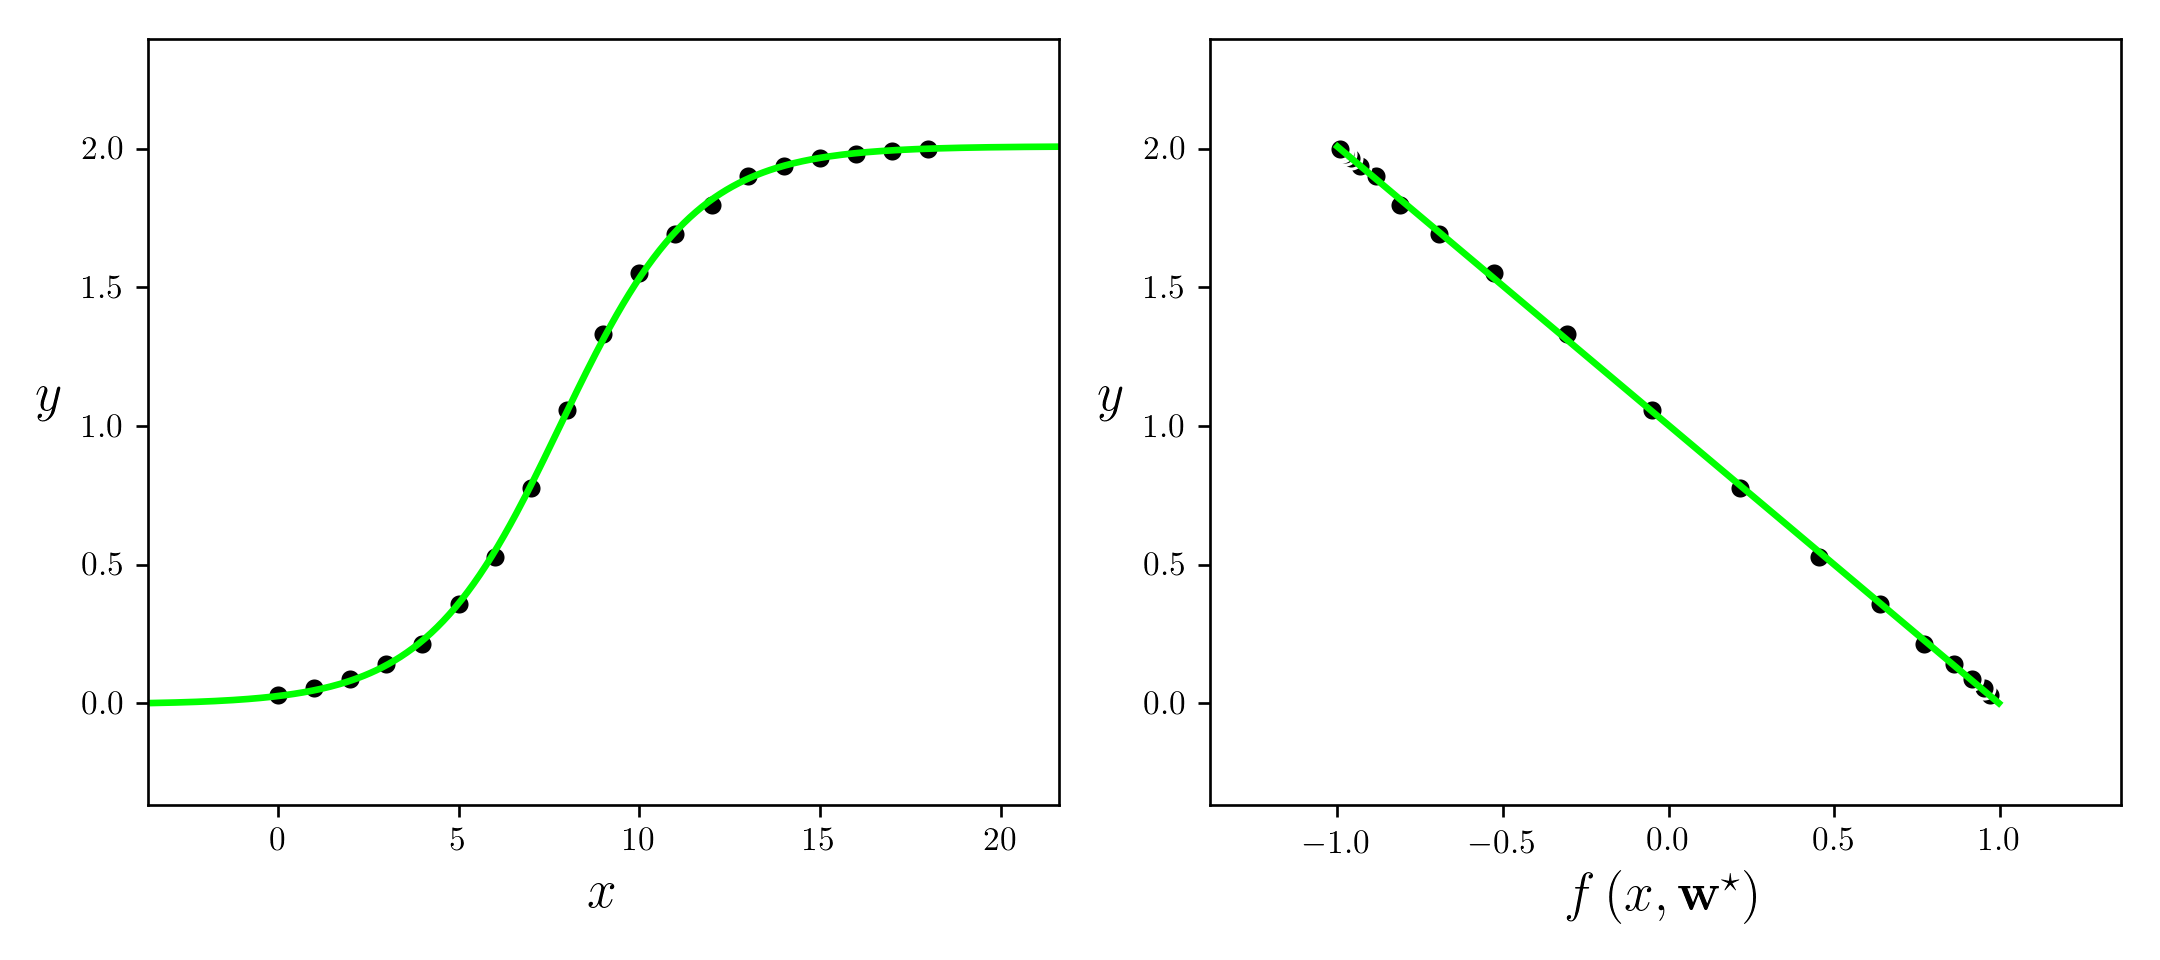

In [22]:
# plot data and fit in original and feature transformed space
ind = np.argmin(runner.cost_history)
w_best = runner.weight_history[ind]
demo.plot_fit_and_feature_space(w_best,runner.model,runner.feature_transform,normalizer = runner.normalizer)

#### <span style="color:#a50e3e;">Example 5. </span> Galileo's ramp experiment

In 1638 Galileo Galilei, infamous for his expulsion from the Catholic church for daring to claim that the earth orbited the sun and not the converse (as was the prevailing belief at the time) published his final book: [Discourses and Mathematical Demonstrations Relating to Two New Sciences](https://books.google.com/books?hl=en&lr=&id=8BhZAAAAYAAJ&oi=fnd&pg=PA11&ots=5pQfKe7Bby&sig=VVWwm0GtVvS9YnydNJXHU_UxBjA#v=onepage&q&f=false). In this book, written as a discourse among three men in the tradition of Aristotle, he described his experimental and philosophical evidence for the notion of uniformly accelerated physical motion. Specifically, Galileo (and others) had intuition that the acceleration of an object due to (the force we now know as) gravity is uniform in time, or in other words that the distance an object falls is directly proportional (i.e., linearly related) to the amount of time it has been traveling, squared. This relationship was empirically solidified using the following ingeniously simple experiment performed by Galileo.

Repeatedly rolling a metal ball down a grooved $\frac{1}{2}$ meter long piece of wood set at an incline as shown in the Figure below, Galileo timed how long the ball took to get $\frac{1}{4}$,$\frac{1}{2}$, $\frac{2}{3}$, $\frac{3}{4}$, and all the way down the wood ramp. 

<p>
<figure>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/Fig_1_12.png' width="80%" height="60%" alt=""/>
  <figcaption>   
<strong>Figure 5:</strong> <em> Figurative illustration of
Galileo's ramp experiment setup used for exploring the relationship
between time and the distance an object falls due to gravity. To perform
this experiment he repeatedly rolled a ball down a ramp and timed
how long it took to get $\frac{1}{4}$,$\frac{1}{2}$, $\frac{2}{3}$,
$\frac{3}{4}$, and all the way down the ramp.  </em>  </figcaption> 
</figure>
</p>

 Why didn't Galileo simply drop the ball from some height and time how long it took to reach certain distances to the ground?  Because no reliable way to measure time yet existed (he had to use a [water clock](https://en.wikipedia.org/wiki/Water_clock) for these experiments)!   Galileo was the one who set humanity on the route towards its first reliable time-piece in his studies of the [pendulum](http://galileo.rice.edu/sci/instruments/pendulum.html)
 
Data from a ([modern reenactment](Straulino, S, "Reconstruction of Galileo Galilei's experiment: the inclined plane", Physics Education 43, 3 2008, pp. 316.)) of these experiments (averaged over 30 trials), results in the 6 data points shown below.  Here the input axis is the number seconds while the output is the portion of the ramp traveled by the ball during the experiments.

<IPython.core.display.Javascript object>


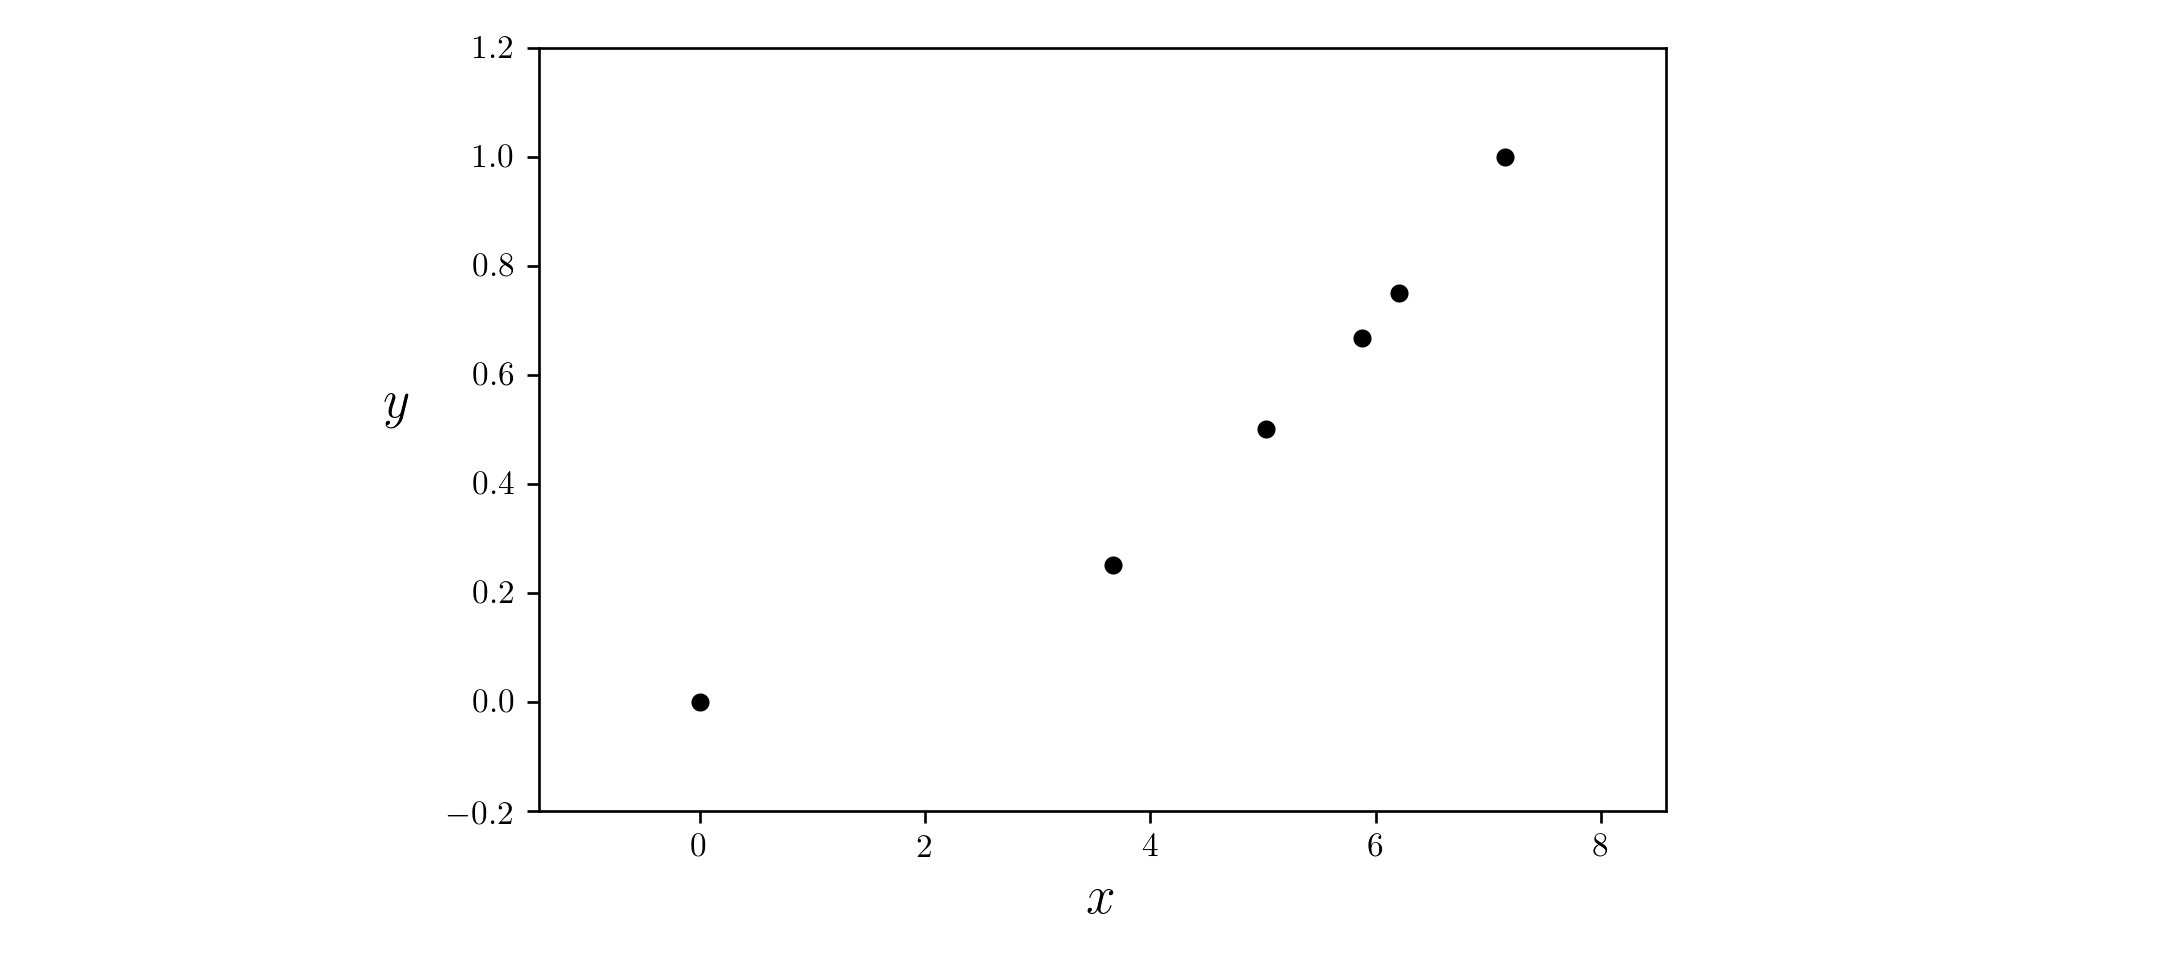

In [127]:
# load data
csvname = datapath + 'galileo_ramp_data.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:,:-1].T
y = data[:,-1:]

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

The data here certainly displays a nonlinear relationship and by viewing it - and using his physical intuition Galileo - intuited a *quadratic* relationship.  Or in our jargon that for some $w_0$, $w_1$, and $w_2$ the modeling function 

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + w_1x + w_2x^2
\end{equation}

provides the correct sort of nonlinearity to explain this data (albeit when the parameters are tuned correctly).  

Notice here how we have 2 feature transformations: the identity $f_1(x) = x$ and the quadratic term $f_2(x) = x^2$, and so we may write the above equivalently as

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + w_1\,f_1(x) + w_2\,f_2(x)
\end{equation}

which clearly shows how we are seeking out a proper linear relationship in the transformed feature space (which in this case is two-dimensional).  Note here - unlike the previous examples - neither of these feature transformations are *fixed* in that they take in no internal weights.

Below implement both feature transformations in a single `Python` function, the `model` function.

In [128]:
def feature_transform(x):
    # calculate feature transform
    f = np.array([(x.flatten()**d) for d in range(1,3)])   
    return f

def model(x,w):    
    # feature transformation 
    f = feature_transform(x)
    
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(f)[1]))
    f = np.vstack((o,f))
    
    # compute linear combination and return
    a = np.dot(f.T,w)
    return a

As in the previous examples we perform standard normalization on the input of this dataset to speed up gradient descent.  This means that we can think of each of our feature transformations as involving this form of normalization as $f_1(x) = \frac{x - \mu}{\sigma}$ and the quadratic term $f_2(x) = \left(\frac{x - \mu}{\sigma}\right)^2$ where $\mu$ and $\sigma$ are the mean and standard deviation of the input data, which we accomplish by feeding normalized input into each.

In [140]:
# create normalizer
normalizer = normalizers.standard_normalizer(x)

# normalize input 
x_normalized = normalizer(x)

# get least squares cost with our given model
least_squares = nonlib.cost_functions.choose_cost(x_normalized,y,model,cost = 'least_squares')

# set random initialization and run gradient descent on standard normalized input
g = least_squares; alpha_choice = 10**(-1); max_its = 50; 
w = 0.1*np.random.randn(3,1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

Now we can plot our original data and nonlinear fit in the original space (left panel below), as well as transformed data and simultaneous *linear* fit in the transformed feature space (right panel below).  Notice that since we have two features in this instance our linear fit is in a space one dimension higher than the original input space defined by $x$.  In other words, the transformed feature space here has *two* inputs: one defined by each of the two features $f_1$ and $f_2$.

<IPython.core.display.Javascript object>


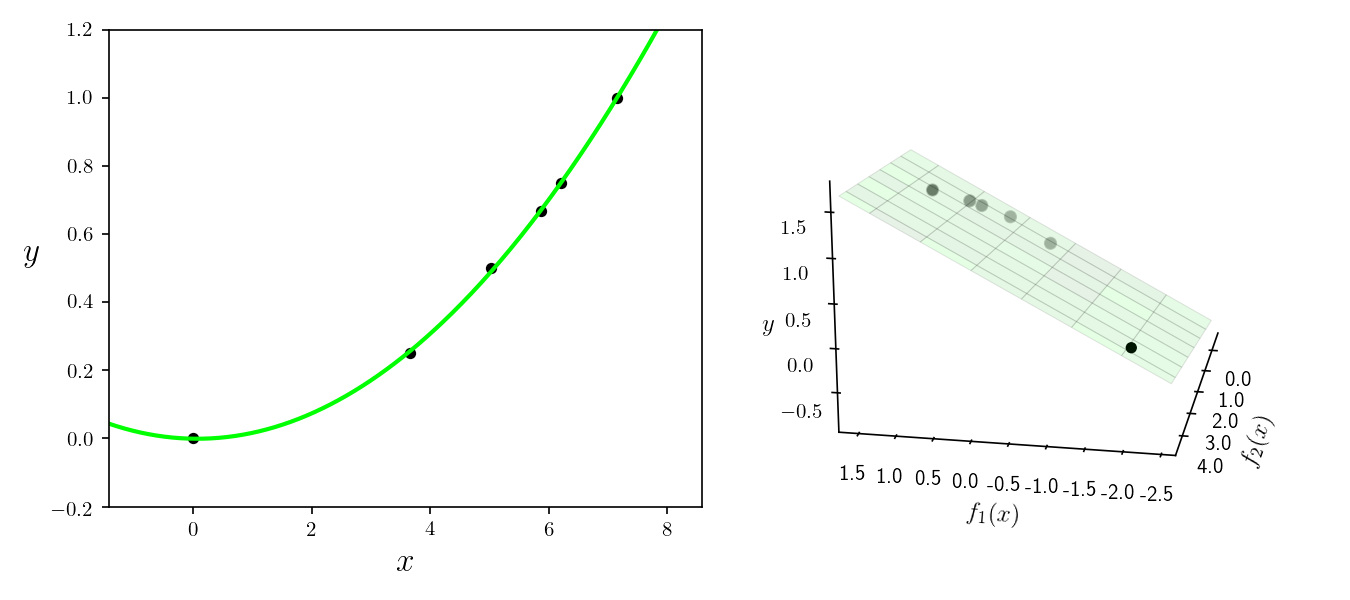

In [142]:
# plot data and fit in original and feature transformed space
ind = np.argmin(cost_history)
w_best = weight_history[ind]
demo.plot_fit_and_feature_space(w_best,model,feature_transform,normalizer = normalizer,view = [25,100])

This is true more generally speaking: the more feature transforms we use the higher the up we go in terms of the dimensions of our transformed feature space / linear fit!  In general if our original input has dimension $N$ - and is written as $\mathbf{x}$ - and we use a `model` function that employs $B$ nonlinear feature transformations as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + {w}_{1}\,f_1\left(\mathbf{x}\right) +  {w}_{2}\,f_2\left(\mathbf{x}\right) + \cdots + w_B\,f_B\left(\mathbf{x}\right)  
\end{equation}

then our original space has $N$ dimensional input, while our transformed feature space is $B$ dimensional.  Note here that the set of all weights $\omega$ contains not only the weights $w_1,\,w_2,...,w_B$ from the linear combination, but also any features's internal parameters as well.